In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# GET THE DATAFRAME.

import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
# df_path = "../../data/raw/hedges-all.tsv"
# df_path = "../../data/raw/studytype_multiclass.tsv"
df = pd.read_csv(df_path, sep="\t")
# df = pd.concat([df * 5])

In [3]:
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.
# COULD be parallelised
from eppi_text_classification import (
    get_features,
    get_labels,
    get_tfidf_and_names,
)

word_features = get_features(
    df,
    # title_key="ti",
    # abstract_key="ab",
    # title_key="TI",
    # abstract_key="AB",
)


number of processes: 12
number of processes: 12


In [4]:
labels = get_labels(
    df,
    # label_column_name="is_rct",
    # positive_class_value="1",
    # label_column_name="Class",
    # positive_class_value="CaseControlStudies",
)
tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [5]:
# PERFORM AN OPTUNA HYPERPARAMETER SEARCH, CAN CHANGE THE SEARCH SPACE IN OPT.PY

from eppi_text_classification import OptunaHyperparameterOptimisation

# hyperparam_ranges = {
#     "min_child_samples": {"low": 1, "high": 30, "log": False},
#     "learning_rate": {"low": 0.1, "high": 0.6, "log": False},
#     "num_leaves": {"low": 2, "high": 50, "log": False},
#     "n_estimators": {"low": 100, "high": 100, "log": False},
#     "min_split_gain": {"low": 1e-6, "high": 10, "log": False},
#     "min_child_weight": {"low": 1e-6, "high": 1e-1, "log": True},
#     "reg_alpha": {"low": 1e-5, "high": 10, "log": True},
#     "reg_lambda": {"low": 1e-5, "high": 10, "log": True},
#     "linear_tree": {"value": True},
# }

hyperparam_ranges = {
    "min_child_samples": {"low": 1, "high": 30, "log": False, "suggest_type": "int"},
    "learning_rate": {"low": 0.1, "high": 0.6, "log": False, "suggest_type": "float"},
    "num_leaves": {"low": 2, "high": 50, "log": False, "suggest_type": "int"},
    "n_estimators": {"low": 100, "high": 500, "log": False, "suggest_type": "int"},
    "min_split_gain": {"low": 1e-6, "high": 10, "log": False, "suggest_type": "float"},
    "min_child_weight": {
        "low": 1e-6,
        "high": 1e-1,
        "log": True,
        "suggest_type": "float",
    },
    "reg_alpha": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
    "reg_lambda": {"low": 1e-5, "high": 10, "log": True, "suggest_type": "float"},
}


optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "lightgbm",
    max_n_search_iterations=300,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
    timeout=1000,
    use_early_terminator=True,
    max_stagnation_iterations=1000,
    wilcoxon_trial_pruner_threshold=None,
    use_worse_than_first_two_pruner=False,
    user_selected_hyperparameter_ranges=hyperparam_ranges,
)

optimiser.delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

Number of processes: 12
sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db
final ranges: {'max_depth': {'low': 1, 'high': 15, 'log': False, 'suggest_type': 'int'}, 'min_child_samples': {'low': 1, 'high': 30, 'log': False, 'suggest_type': 'int'}, 'num_leaves': {'low': 2, 'high': 50, 'log': False, 'suggest_type': 'int'}, 'n_estimators': {'low': 100, 'high': 500, 'log': False, 'suggest_type': 'int'}, 'learning_rate': {'low': 0.1, 'high': 0.6, 'log': False, 'suggest_type': 'float'}, 'min_split_gain': {'low': 1e-06, 'high': 10, 'log': False, 'suggest_type': 'float'}, 'min_child_weight': {'low': 1e-06, 'high': 0.1, 'log': True, 'suggest_type': 'float'}, 'reg_alpha': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'reg_lambda': {'low': 1e-05, 'high': 10, 'log': True, 'suggest_type': 'float'}, 'data_sample_strategy': {'value': 'bagging', 'suggest_type': 'singular'}, 'boosting_type': {'value': 'gbdt', 'suggest_type': 'singular'}

[I 2025-02-24 09:09:58,617] A new study created in RDB with name: lgbm_binary
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:406: ExperimentalWarning: BestValueStagnationEvaluator is experimental (supported from v3.4.0). The interface can change in the future.
  improvement_evaluator=BestValueStagnationEvaluator(
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:409: ExperimentalWarning: StaticErrorEvaluator is experimental (supported from v3.2.0). The interface can change in the future.
  error_evaluator=StaticErrorEvaluator(constant=0),
/Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/eppi_text_classification/single_process_opt.py:405: ExperimentalWarning: Terminator is experimental (supported from v3.2.0). The interface can change in the future.
  terminator = Terminator(
/Users/sjmolyneux/Document

Finished trial with scores: [0.36234413965087287, 0.7467996674979219, 0.6577825159914713]
Finished trial with scores: [0.5021612635078969, 0.43524522028262674, 0.855366027007818]
Finished trial with scores: [0.6339152119700748, 0.43740648379052366, 0.9304371002132197]
Finished trial with scores: [0.8340814630091438, 0.7482128013300082, 0.9341684434968018]
Finished trial with scores: [0.9150457190357439, 0.8771404821280133, 0.9694385216773277]


[I 2025-02-24 09:09:59,683] Trial 4 finished with value: 0.5889754410467555 and parameters: {'min_split_gain': 9.997427907547706, 'reg_alpha': 0.0018098156831817724, 'max_depth': 14, 'min_child_weight': 0.018637623632398848, 'num_leaves': 45, 'reg_lambda': 0.0006741563717097696, 'n_estimators': 379, 'min_child_samples': 29, 'learning_rate': 0.5880282588579121}. Best is trial 4 with value: 0.5889754410467555.
[I 2025-02-24 09:09:59,707] Trial 2 finished with value: 0.6672529319912727 and parameters: {'max_depth': 11, 'min_child_weight': 0.007400749381902929, 'reg_alpha': 0.15888873771334353, 'num_leaves': 44, 'min_split_gain': 4.723637450178216, 'reg_lambda': 5.593725218315715e-05, 'n_estimators': 112, 'learning_rate': 0.3554294683986816, 'min_child_samples': 22}. Best is trial 2 with value: 0.6672529319912727.
[I 2025-02-24 09:09:59,715] Trial 8 finished with value: 0.5975908369327806 and parameters: {'num_leaves': 19, 'learning_rate': 0.48876638247588433, 'min_child_weight': 4.3929200

Finished trial with scores: [0.8972568578553617, 0.6752285951787199, 0.8781982942430704]
Finished trial with scores: [0.9211970074812967, 0.8350789692435578, 0.9516702203269368]
Finished trial with scores: [0.9236907730673316, 0.7527847049044056, 0.9253731343283582]
Finished trial with scores: [0.7615960099750623, 0.6056525353283458, 0.7860696517412935]
Finished trial with scores: [0.9118869492934331, 0.8985868661679136, 0.9589552238805971]


[I 2025-02-24 09:09:59,935] Trial 1 finished with value: 0.8168945824257173 and parameters: {'num_leaves': 24, 'learning_rate': 0.31981011250623415, 'reg_alpha': 0.007221927003134198, 'min_split_gain': 8.01534192227189, 'max_depth': 14, 'reg_lambda': 0.011059386309689927, 'min_child_weight': 0.0012323593491160335, 'min_child_samples': 11, 'n_estimators': 198}. Best is trial 6 with value: 0.9205415742803617.
[I 2025-02-24 09:10:00,002] Trial 5 finished with value: 0.9026487323505972 and parameters: {'num_leaves': 7, 'reg_lambda': 0.0001359946570046228, 'reg_alpha': 0.00016495557086898955, 'learning_rate': 0.10314623431941813, 'min_child_samples': 21, 'min_split_gain': 7.8775345510171455, 'min_child_weight': 0.005542420436922564, 'max_depth': 3, 'n_estimators': 242}. Best is trial 6 with value: 0.9205415742803617.
[I 2025-02-24 09:10:00,021] Trial 7 finished with value: 0.8672828707666985 and parameters: {'max_depth': 8, 'n_estimators': 222, 'num_leaves': 40, 'min_child_weight': 0.000813

Finished trial with scores: [0.829925187032419, 0.6610141313383209, 0.8917910447761195]
Finished trial with scores: [0.8194513715710723, 0.8179551122194515, 0.9166666666666666]
Finished trial with scores: [0.772236076475478, 0.570573566084788, 0.8049928926794598]
Finished trial with scores: [0.9348295926849544, 0.8483790523690773, 0.9479388770433547]


[I 2025-02-24 09:10:00,882] Trial 12 finished with value: 0.8513577168190635 and parameters: {'min_split_gain': 2.056234066265615, 'reg_alpha': 0.012806969621038404, 'max_depth': 9, 'min_child_weight': 0.00022449195093571922, 'num_leaves': 34, 'reg_lambda': 0.000690810138315468, 'n_estimators': 349, 'min_child_samples': 20, 'learning_rate': 0.2666926247833621}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:00,894] Trial 10 finished with value: 0.7942434543822866 and parameters: {'reg_alpha': 0.00024977369767196307, 'min_split_gain': 0.42937136602120757, 'min_child_samples': 3, 'max_depth': 9, 'min_child_weight': 0.05758612399982487, 'n_estimators': 185, 'learning_rate': 0.45184511303313524, 'reg_lambda': 0.37998347252659553, 'num_leaves': 13}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:01,020] Trial 14 finished with value: 0.7159341784132419 and parameters: {'num_leaves': 6, 'learning_rate': 0.5279399166769344, 'min_child_weight': 1.0741

Finished trial with scores: [0.559019118869493, 0.6821280133000831, 0.40440653873489696]
Finished trial with scores: [0.6870324189526185, 0.5792186201163757, 0.9153340440653874]


[I 2025-02-24 09:10:01,112] Trial 15 finished with value: 0.548517890301491 and parameters: {'max_depth': 4, 'min_split_gain': 8.00133078671205, 'min_child_samples': 26, 'min_child_weight': 4.93096497166008e-06, 'reg_lambda': 0.0002265932966552118, 'learning_rate': 0.5245781627333714, 'num_leaves': 23, 'reg_alpha': 0.00010676613496904764, 'n_estimators': 293}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:01,204] Trial 16 finished with value: 0.7271950277114606 and parameters: {'max_depth': 2, 'min_child_weight': 0.00018455493915151323, 'reg_lambda': 0.3443119687848161, 'learning_rate': 0.48025925339286246, 'min_split_gain': 7.64235520747533, 'min_child_samples': 18, 'n_estimators': 113, 'num_leaves': 49, 'reg_alpha': 7.197224347440009}. Best is trial 11 with value: 0.9231430131139812.


Finished trial with scores: [0.8298420615128845, 0.7391521197007481, 0.9164001421464109]
Finished trial with scores: [0.6916043225270159, 0.6334995843724023, 0.7547974413646055]


[I 2025-02-24 09:10:01,372] Trial 17 finished with value: 0.8284647744533479 and parameters: {'num_leaves': 27, 'learning_rate': 0.31768916686134396, 'reg_alpha': 2.5100280099126005e-05, 'min_split_gain': 1.9619247937242563, 'max_depth': 13, 'reg_lambda': 0.00014252718588450748, 'min_child_weight': 4.394507736105923e-06, 'min_child_samples': 12, 'n_estimators': 192}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:01,541] Trial 18 finished with value: 0.6933004494213412 and parameters: {'num_leaves': 23, 'reg_lambda': 8.428146883480414e-05, 'reg_alpha': 2.008539285645727e-05, 'learning_rate': 0.5268612683778994, 'min_child_samples': 13, 'min_split_gain': 3.800745591096152, 'min_child_weight': 0.07629483587418376, 'max_depth': 4, 'n_estimators': 289}. Best is trial 11 with value: 0.9231430131139812.


Finished trial with scores: [0.9032418952618454, 0.8074812967581046, 0.937633262260128]
Finished trial with scores: [0.7778886118038237, 0.7767248545303408, 0.8473702914001421]


[I 2025-02-24 09:10:02,019] Trial 25 finished with value: 0.882785484760026 and parameters: {'num_leaves': 16, 'learning_rate': 0.19896102627371562, 'min_child_weight': 1.0738359113019606e-06, 'reg_alpha': 1.3364140057084128e-05, 'reg_lambda': 7.636100309799363, 'min_split_gain': 3.3770961612471524, 'max_depth': 12, 'n_estimators': 282, 'min_child_samples': 6}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:02,055] Trial 0 finished with value: 0.8006612525781022 and parameters: {'min_split_gain': 3.1773217792126602, 'reg_alpha': 0.0071050681696577574, 'reg_lambda': 0.00016125328199260506, 'learning_rate': 0.2918907908012154, 'min_child_samples': 1, 'max_depth': 13, 'num_leaves': 28, 'n_estimators': 468, 'min_child_weight': 1.812232495289604e-05}. Best is trial 11 with value: 0.9231430131139812.


Finished trial with scores: [0.9108894430590191, 0.800166251039069, 0.9289267945984363]
Finished trial with scores: [0.9246882793017456, 0.8891105569409808, 0.9484719260838663]
Finished trial with scores: [0.8911055694098088, 0.8262676641729012, 0.935856432125089]
Finished trial with scores: [0.9064006650041563, 0.7768911055694098, 0.9589552238805971]


[I 2025-02-24 09:10:02,262] Trial 28 finished with value: 0.8799941628988415 and parameters: {'num_leaves': 17, 'learning_rate': 0.1903197050345767, 'reg_alpha': 0.12187360776189417, 'min_split_gain': 3.8396286847913075, 'max_depth': 5, 'reg_lambda': 6.041159238071818, 'min_child_weight': 3.41151958391157e-05, 'min_child_samples': 7, 'n_estimators': 289}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:02,288] Trial 23 finished with value: 0.920756920775531 and parameters: {'min_split_gain': 0.10041292975839144, 'reg_alpha': 1.626308162115884e-05, 'max_depth': 1, 'min_child_weight': 1.1615740110411502e-06, 'num_leaves': 32, 'reg_lambda': 3.384398066574358, 'n_estimators': 482, 'min_child_samples': 7, 'learning_rate': 0.19929262990202973}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:02,384] Trial 26 finished with value: 0.8844098885692663 and parameters: {'max_depth': 12, 'min_split_gain': 3.2956721668889712, 'min_child_samples': 5, 'min_chi

Finished trial with scores: [0.8997506234413966, 0.8369077306733167, 0.9481165600568586]
Finished trial with scores: [0.8995843724023275, 0.8182876142975893, 0.9227078891257996]
Finished trial with scores: [0.9582709891936825, 0.8522028262676642, 0.9509594882729211]
Finished trial with scores: [0.9456359102244389, 0.8217788861180382, 0.9482942430703624]


[I 2025-02-24 09:10:02,499] Trial 27 finished with value: 0.8949249713905241 and parameters: {'max_depth': 12, 'min_child_weight': 2.3403275679014324e-06, 'reg_lambda': 8.208924037128837, 'learning_rate': 0.18543018674639472, 'min_split_gain': 3.545065655329548, 'min_child_samples': 5, 'n_estimators': 468, 'num_leaves': 16, 'reg_alpha': 1.0497425791507409e-05}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:02,565] Trial 24 finished with value: 0.8801932919419055 and parameters: {'max_depth': 12, 'min_child_weight': 1.9967888017252872e-06, 'reg_alpha': 1.0460641508356979e-05, 'num_leaves': 17, 'min_split_gain': 3.4771451159309095, 'reg_lambda': 6.76695728243374, 'n_estimators': 462, 'learning_rate': 0.1891544555091907, 'min_child_samples': 4}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:02,677] Trial 29 finished with value: 0.9052363464709465 and parameters: {'num_leaves': 16, 'reg_lambda': 5.655048343856535, 'reg_alpha': 0.188662916783100

Finished trial with scores: [0.9015793848711554, 0.770739817123857, 0.9418976545842218]
Finished trial with scores: [0.9089775561097256, 0.775893599334996, 0.9596659559346126]
Finished trial with scores: [0.9100581878636742, 0.7850374064837906, 0.9418976545842218]
Finished trial with scores: [0.9334995843724023, 0.8799667497921861, 0.9541577825159915]
Finished trial with scores: [0.9266832917705736, 0.8962593516209477, 0.9502487562189055]
Finished trial with scores: [0.9246882793017457, 0.9049044056525354, 0.9459843638948117]
Finished trial with scores: [0.9078969243557772, 0.7735660847880299, 0.9447405828002843]
Finished trial with scores: [0.9334995843724023, 0.9067331670822942, 0.9449182658137881]
Finished trial with scores: [0.9310058187863673, 0.8955943474646717, 0.9500710732054016]


[I 2025-02-24 09:10:03,039] Trial 31 finished with value: 0.8815123704597781 and parameters: {'min_split_gain': 0.21046674601813642, 'reg_alpha': 0.19160250180317623, 'reg_lambda': 4.636841677912448, 'learning_rate': 0.1878798872348443, 'min_child_samples': 25, 'max_depth': 6, 'num_leaves': 2, 'n_estimators': 158, 'min_child_weight': 7.282105165862959e-05}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:03,055] Trial 21 finished with value: 0.8789977496438955 and parameters: {'num_leaves': 33, 'learning_rate': 0.20916592995616534, 'min_child_samples': 1, 'reg_alpha': 1.414510826516757e-05, 'min_split_gain': 2.162842101314456, 'reg_lambda': 7.000734155765904, 'min_child_weight': 1.0950647396157337e-06, 'n_estimators': 327, 'max_depth': 1}. Best is trial 11 with value: 0.9231430131139812.
[I 2025-02-24 09:10:03,084] Trial 33 finished with value: 0.92254137222686 and parameters: {'num_leaves': 35, 'learning_rate': 0.18721224962256527, 'reg_alpha': 0.07127103193723332

Finished trial with scores: [0.9330008312551954, 0.8849542809642561, 0.9555792466240227]
Finished trial with scores: [0.9250207813798836, 0.827930174563591, 0.939587775408671]


[I 2025-02-24 09:10:03,323] Trial 32 finished with value: 0.9245114529478248 and parameters: {'min_split_gain': 0.06789709342603523, 'reg_alpha': 0.07171681749501124, 'max_depth': 1, 'min_child_weight': 1.0538172044593787e-06, 'num_leaves': 34, 'reg_lambda': 2.0743802554711452, 'n_estimators': 465, 'min_child_samples': 25, 'learning_rate': 0.18896152659740134}. Best is trial 37 with value: 0.9283836724228283.
[I 2025-02-24 09:10:03,483] Trial 38 finished with value: 0.8975129104507152 and parameters: {'num_leaves': 34, 'reg_lambda': 1.1388375077074451e-05, 'reg_alpha': 6.066159054342559e-05, 'learning_rate': 0.151578813979108, 'min_child_samples': 9, 'min_split_gain': 1.0876505105986771, 'min_child_weight': 1.4107516168301222e-05, 'max_depth': 10, 'n_estimators': 243}. Best is trial 37 with value: 0.9283836724228283.


Finished trial with scores: [0.9256857855361598, 0.9037406483790524, 0.9580668088130775]
Finished trial with scores: [0.9310058187863675, 0.9025768911055694, 0.9545131485429993]
Finished trial with scores: [0.7644222776392352, 0.6043225270157939, 0.7844705046197583]
Finished trial with scores: [0.8058187863674149, 0.8985868661679136, 0.9390547263681592]


[I 2025-02-24 09:10:03,711] Trial 40 finished with value: 0.9291644142427632 and parameters: {'min_split_gain': 1.0410955611054218, 'reg_alpha': 5.51305283453579e-05, 'reg_lambda': 1.1404666507456627, 'learning_rate': 0.13466487662882926, 'min_child_samples': 9, 'max_depth': 2, 'num_leaves': 37, 'n_estimators': 249, 'min_child_weight': 1.1914774983053134e-05}. Best is trial 40 with value: 0.9291644142427632.
[I 2025-02-24 09:10:03,726] Trial 41 finished with value: 0.9293652861449787 and parameters: {'num_leaves': 38, 'learning_rate': 0.1385890262369783, 'min_child_samples': 19, 'reg_alpha': 5.7757774535884136e-05, 'min_split_gain': 1.175149846722686, 'reg_lambda': 1.1442496880975912, 'min_child_weight': 9.217890600798202e-06, 'n_estimators': 428, 'max_depth': 2}. Best is trial 41 with value: 0.9293652861449787.
[I 2025-02-24 09:10:03,910] Trial 42 finished with value: 0.8811534596344958 and parameters: {'reg_alpha': 5.707229576679062e-05, 'min_split_gain': 1.209156317414701, 'min_chil

Finished trial with scores: [0.9266832917705735, 0.9092269326683291, 0.9570007107320541]
Finished trial with scores: [0.7418121363258521, 0.7644222776392353, 0.8509239516702203]
Finished trial with scores: [0.9443059019118869, 0.9027431421446384, 0.9731698649609096]
Finished trial with scores: [0.9379883624272651, 0.9065669160432253, 0.9689054726368159]
Finished trial with scores: [0.9404821280133001, 0.8924355777223608, 0.9690831556503199]
Finished trial with scores: [0.9506234413965088, 0.9014131338320864, 0.9790334044065387]
Finished trial with scores: [0.9265170407315046, 0.8766417290108063, 0.9617981520966595]


[I 2025-02-24 09:10:03,987] Trial 39 finished with value: 0.9309703117236522 and parameters: {'min_split_gain': 1.1650108063819937, 'max_depth': 2, 'reg_alpha': 5.8286133481991564e-05, 'min_child_weight': 1.0590701114254807e-05, 'n_estimators': 497, 'reg_lambda': 1.6958945421109646, 'num_leaves': 30, 'min_child_samples': 8, 'learning_rate': 0.14427891143414923}. Best is trial 39 with value: 0.9309703117236522.
[I 2025-02-24 09:10:04,056] Trial 44 finished with value: 0.7857194552117693 and parameters: {'num_leaves': 38, 'learning_rate': 0.3573219283445356, 'min_child_weight': 1.362065215172535e-05, 'reg_alpha': 4.824287469178415e-05, 'reg_lambda': 0.10773581604352211, 'min_split_gain': 1.1496898107578992, 'max_depth': 3, 'n_estimators': 435, 'min_child_samples': 10}. Best is trial 39 with value: 0.9309703117236522.
[I 2025-02-24 09:10:04,063] Trial 46 finished with value: 0.9400729696724782 and parameters: {'max_depth': 3, 'n_estimators': 409, 'num_leaves': 38, 'min_child_weight': 5.67

Finished trial with scores: [0.9482959268495428, 0.8984206151288445, 0.9779673063255153]
Finished trial with scores: [0.9349958437240232, 0.8566916043225271, 0.9719260838663824]
Finished trial with scores: [0.9464671654197839, 0.8921030756442229, 0.9699715707178393]
Finished trial with scores: [0.9369908561928512, 0.8834580216126351, 0.96090973702914]
Ending process, stopping_event set.
Ending process, stopping_event set.


[I 2025-02-24 09:10:04,242] Trial 49 finished with value: 0.9415612827679675 and parameters: {'min_split_gain': 1.1299878942460844, 'reg_alpha': 0.0016082776879674148, 'max_depth': 3, 'min_child_weight': 1.5394336217928243e-05, 'num_leaves': 40, 'reg_lambda': 0.1689733598254991, 'n_estimators': 436, 'min_child_samples': 9, 'learning_rate': 0.10047893032918004}. Best is trial 45 with value: 0.9436899932117114.
[I 2025-02-24 09:10:04,271] Trial 52 finished with value: 0.9212045106376442 and parameters: {'num_leaves': 38, 'learning_rate': 0.1164267792320761, 'min_child_samples': 18, 'reg_alpha': 0.0005637789637629271, 'min_split_gain': 1.3916917804536277, 'reg_lambda': 0.6814949493386643, 'min_child_weight': 6.8075089363001096e-06, 'n_estimators': 425, 'max_depth': 3}. Best is trial 45 with value: 0.9436899932117114.
[I 2025-02-24 09:10:04,300] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,306] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,378

Finished trial with scores: [0.9369908561928512, 0.8688279301745636, 0.9706823027718551]
Ending process, stopping_event set.
Finished trial with scores: [0.9085619285120532, 0.8596841230257689, 0.9612651030561479]
Ending process, stopping_event set.
Finished trial with scores: [0.9338320864505403, 0.8418952618453865, 0.9614427860696517]
Ending process, stopping_event set.
Finished trial with scores: [0.9348295926849542, 0.8101413133832087, 0.9738805970149255]
Ending process, stopping_event set.
Finished trial with scores: [0.9256857855361597, 0.8517040731504573, 0.9703269367448472]
Ending process, stopping_event set.


[I 2025-02-24 09:10:04,457] Trial 54 finished with value: 0.9255003630464232 and parameters: {'max_depth': 3, 'min_child_weight': 6.127660861154648e-06, 'reg_alpha': 0.00058825687074908, 'num_leaves': 42, 'min_split_gain': 1.5127447157302276, 'reg_lambda': 0.6877948299568106, 'n_estimators': 264, 'learning_rate': 0.10691657231791077, 'min_child_samples': 12}. Best is trial 45 with value: 0.9436899932117114.
[I 2025-02-24 09:10:04,489] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,492] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,547] Trial 55 finished with value: 0.9098370515313233 and parameters: {'min_split_gain': 4.751344050108369, 'max_depth': 2, 'reg_alpha': 0.0004065188779663433, 'min_child_weight': 2.478591356939412e-05, 'n_estimators': 376, 'reg_lambda': 0.6763455038141147, 'num_leaves': 41, 'min_child_samples': 18, 'learning_rate': 0.10712818080054112}. Best is trial 45 with value: 0.9436899932117114.
[I 2025-02-24 09:10:04,548] T

Finished trial with scores: [0.9246882793017456, 0.8342477140482129, 0.9749466950959489]
Ending process, stopping_event set.


[I 2025-02-24 09:10:04,677] Trial 58 finished with value: 0.9112942294819691 and parameters: {'num_leaves': 41, 'learning_rate': 0.10405614019978947, 'reg_alpha': 0.0003243858128540555, 'min_split_gain': 2.852345723736403, 'max_depth': 4, 'reg_lambda': 0.03530859704030308, 'min_child_weight': 0.00012478541555521503, 'min_child_samples': 13, 'n_estimators': 392}. Best is trial 45 with value: 0.9436899932117114.
[I 2025-02-24 09:10:04,692] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,699] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,734] The study has been stopped by the terminator.
[I 2025-02-24 09:10:04,738] The study has been stopped by the terminator.


In [6]:
import optuna

study = optuna.create_study(
    study_name="lgbm_binary",
    storage="sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db",
    direction="maximize",
    load_if_exists=True,
)

import jsonpickle

best_trial = study.best_trial
best_params = best_trial.user_attrs["all_params"]
best_params = jsonpickle.decode(best_params, keys=True)


[I 2025-02-24 09:10:04,954] Using an existing study with name 'lgbm_binary' instead of creating a new one.


In [7]:
from eppi_text_classification.plots.optuna_plots import create_all_optuna_plots

create_all_optuna_plots(study, save_dir="optuna_plots")

In [8]:
# FIT THE MODEL

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

# params = dict(
#     verbosity=-1,
#     boosting_type="gbdt",
#     max_depth=4,
#     min_child_samples=30,
#     learning_rate=0.1245928917280467,
#     num_leaves=6,
#     n_estimators=1000,
#     subsample_for_bin=20000,
#     subsample=1.0,
#     objective="binary",
#     scale_pos_weight=27,
#     min_split_gain=2.52381000405986e-06,
#     min_child_weight=5.544840854157574e-06,
#     reg_alpha=3.629909607712911e-05,
#     reg_lambda=3.671749546766942e-05,
#     n_jobs=-1,
#     # linear_tree=True,
#     metric="auc",
#     # max_bin=255,
#     # tree_method="exact",
#     # grow_policy="lossguide",
#     # sampling_method="uniform",
# )
from copy import deepcopy

params = deepcopy(best_params)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)
num_boost_round = params.pop("n_estimators")
dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=True)
model = lgb.train(params, dtrain, num_boost_round=num_boost_round)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [9]:
# CREATE ROC CURVE TO SELECT THRESHOLD p

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plots.roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
# y_test_pred_probs = model.predict(X_test)
plotly_roc(y_test, y_test_pred_probs)

In [10]:
from eppi_text_classification.plots.select_threshold import select_threshold_plot

select_threshold_plot(y_test, y_test_pred_probs)

Generated HTML saved to select_threshold_plot.html


In [12]:
import jsonpickle

from eppi_text_classification.model_stability import (
    predict_cv_metrics,
    predict_cv_scores,
)
from eppi_text_classification.plots.box_plot import generate_box_plot_html
from eppi_text_classification.plots.histogram import (
    create_histogram_html,
    postive_negative_scores_histogram_html,
)

best_trial = study.best_trial
best_params = best_trial.user_attrs["all_params"]
best_params = jsonpickle.decode(best_params, keys=True)

postive_negative_scores_histogram_html(
    y_test, y_test_pred_probs, savepath="pos_neg_hist.html"
)

cv_scores = predict_cv_scores(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    nfolds=5,
    num_cv_repeats=1,
)
generate_box_plot_html(
    cv_scores,
    ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"],
    "AUC",
    xaxis_title="Fold",
    yaxis_title="AUC",
    savepath="box_plot.html",
)

HTML file saved at pos_neg_hist.html
HTML file saved at: box_plot.html


In [16]:
from eppi_text_classification.plots.learning_curve import create_learning_curve_html

create_learning_curve_html(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    savepath="learning_curve.html",
)

Saved learning curve plot to learning_curve.html


In [17]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)

threshold = get_raw_threshold(model, X_test, y_test, target_tpr=0.93)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [18]:
from eppi_text_classification.plots.histogram import (
    create_histogram_html,
    postive_negative_scores_histogram_html,
)

from eppi_text_classification.model_stability import (
    predict_cv_metrics,
    predict_cv_scores,
)

import jsonpickle

best_trial = study.best_trial
best_params = best_trial.user_attrs["all_params"]
best_params = jsonpickle.decode(best_params, keys=True)


auc_scores, recall_scores, fpr_scores = predict_cv_metrics(
    tfidf_scores,
    labels,
    "lightgbm",
    best_params,
    nfolds=3,
    num_cv_repeats=100,
    threshold=threshold,
)
create_histogram_html(auc_scores, savepath="lgbm_auc_hist.html")
create_histogram_html(recall_scores, savepath="lgbm_recall_hist.html")
create_histogram_html(fpr_scores, savepath="lgbm_fpr.html")

HTML file saved at lgbm_auc_hist.html
HTML file saved at lgbm_recall_hist.html
HTML file saved at lgbm_fpr.html


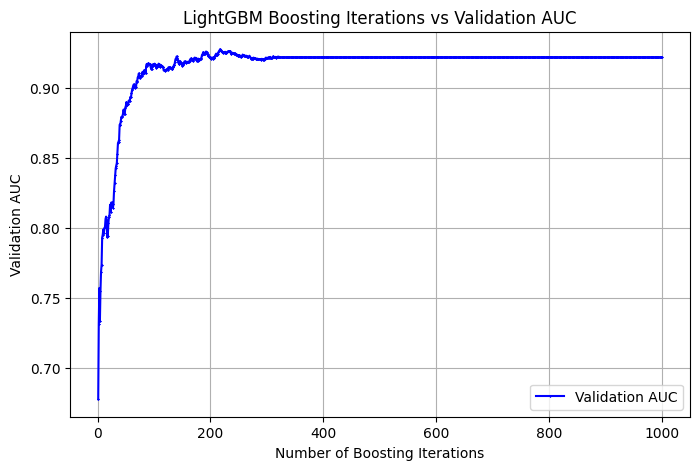

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

dval = lgb.Dataset(X_test, label=y_test, free_raw_data=True)
# Define the range of estimators


evals_result = {}  # Stores validation results
eval_callback = lgb.record_evaluation(evals_result)  # Callback to record results

model = lgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,  # Maximum boosting rounds
    valid_sets=[dval],
    valid_names=["Validation"],
    callbacks=[eval_callback],  # Stores metrics
    # early_stopping_rounds=10,  # Stop if no improvement in 10 rounds
    # verbose_eval=False  # Suppress logging
)

# Extract validation AUC scores
iterations = list(range(1, len(evals_result["Validation"]["auc"]) + 1))
validation_auc = evals_result["Validation"]["auc"]

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(
    iterations,
    validation_auc,
    marker="x",
    linestyle="-",
    color="b",
    label="Validation AUC",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Validation AUC")
plt.title("LightGBM Boosting Iterations vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

dict_keys(['valid auc-mean', 'valid auc-stdv'])


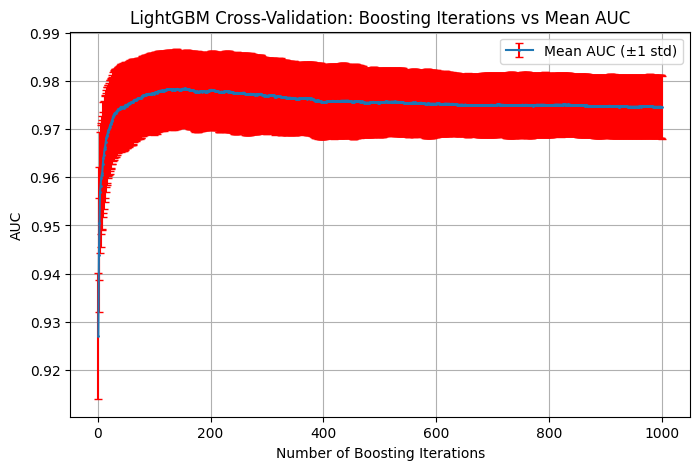

In [15]:
cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    nfold=5,  # Number of folds
    stratified=True,  # Stratified sampling for classification
    shuffle=True,  # Shuffle the data before splitting
    # early_stopping_rounds=10,   # Early stopping
    # verbose_eval=False,         # Suppress detailed logging
    seed=42,  # Reproducibility
)

# lgb.cv returns a dictionary containing the mean and standard deviation
# of the metric values across folds for each boosting iteration.
# Usually with metric='auc', you get:
# - cv_results["auc-mean"]
# - cv_results["auc-stdv"]

print(cv_results.keys())
# Extract the mean and standard deviation of the AUC across folds
mean_auc = cv_results["valid auc-mean"]
std_auc = cv_results["valid auc-stdv"]

# Create a list of iteration numbers
iterations = np.arange(1, len(mean_auc) + 1)

# Plot mean AUC vs boosting iterations (with error bars for standard deviation)
plt.figure(figsize=(8, 5))
plt.errorbar(
    iterations,
    mean_auc,
    yerr=std_auc,
    fmt="-o",
    ecolor="r",
    capsize=3,
    label="Mean AUC (±1 std)",
    markersize=1,
)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("AUC")
plt.title("LightGBM Cross-Validation: Boosting Iterations vs Mean AUC")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

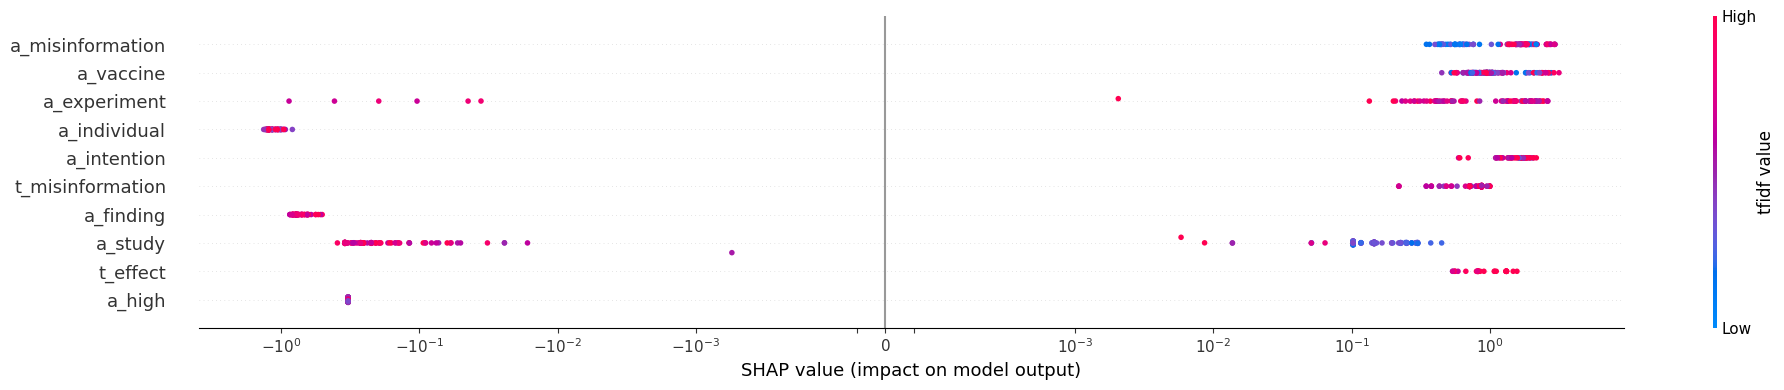

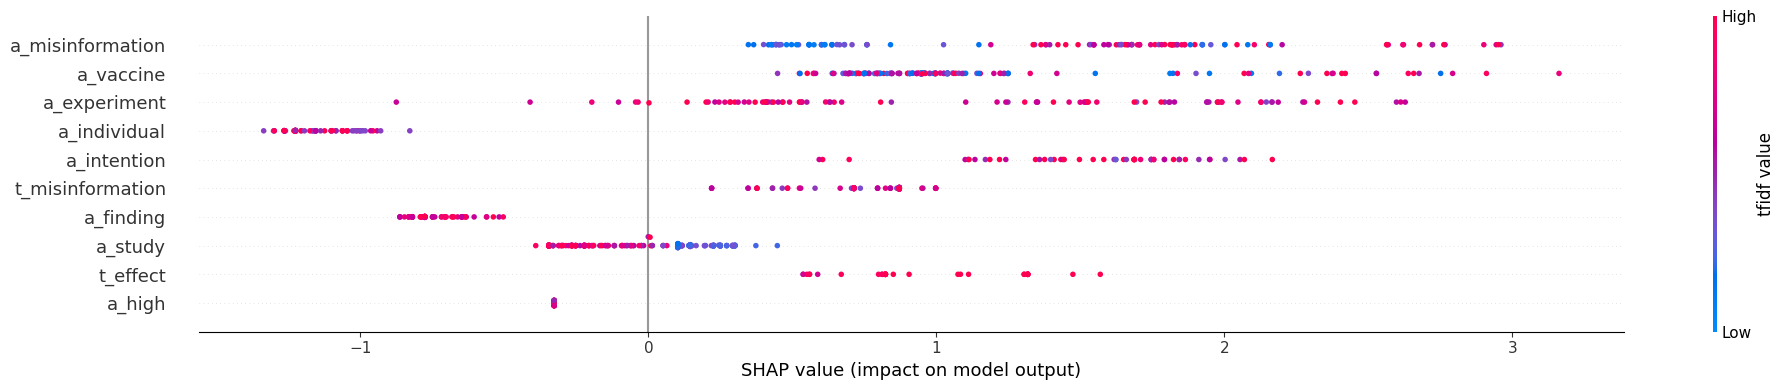

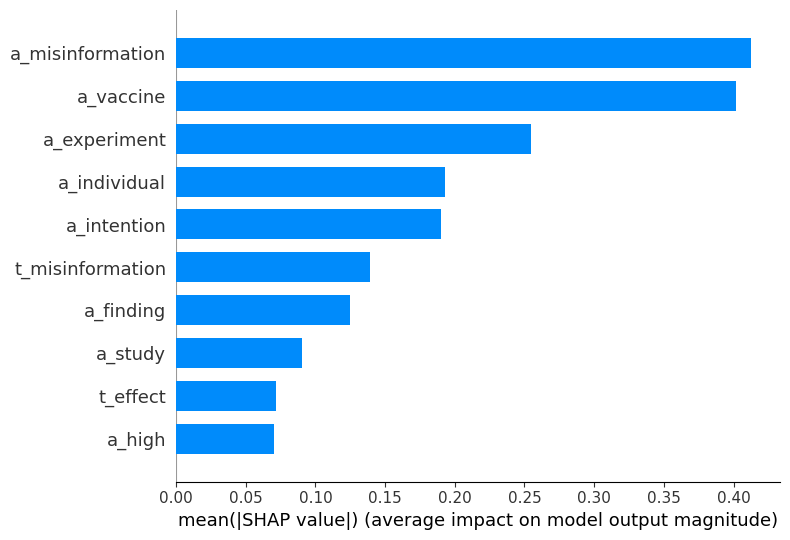

In [20]:
from eppi_text_classification import ShapPlotter

shap_plotter = ShapPlotter(
    model,
    X_test,
    feature_names,
)
dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

Truth: 0
Prediction: [1]
Shap value: -3.3693615514807203
Prediction score: [-3.36936149]


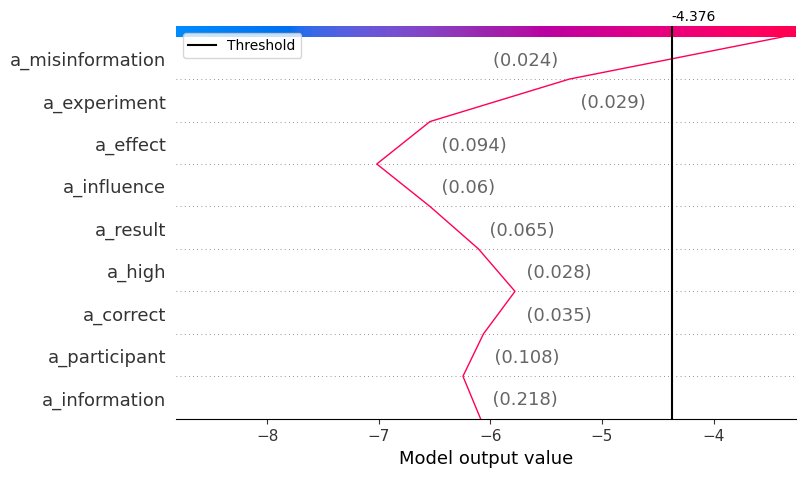

Truth: 0
Prediction: [1]
Shap value: 0.6757384547941587
Prediction score: [0.67573846]


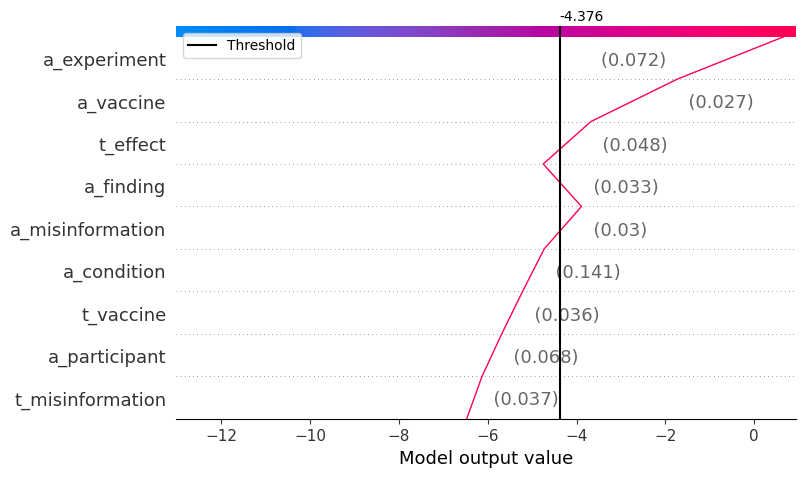

Truth: 0
Prediction: [0]
Shap value: -6.56562403030915
Prediction score: [-6.56562405]


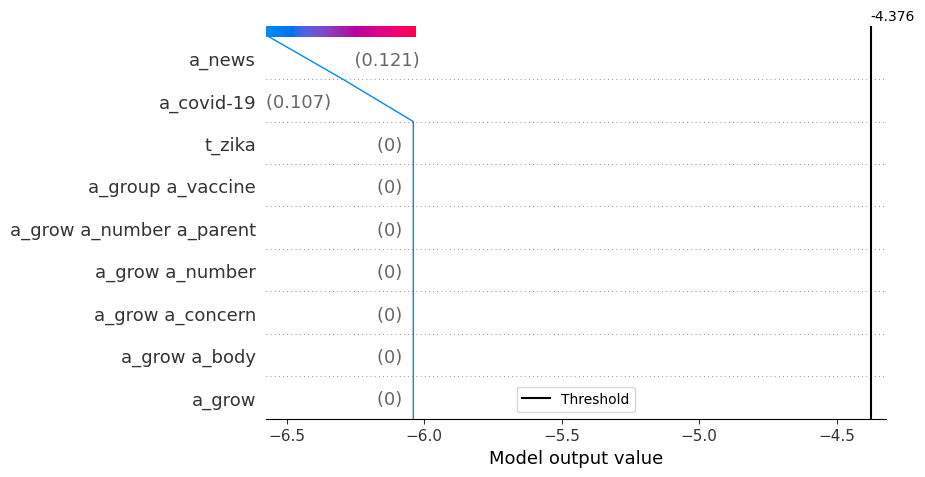

Truth: 0
Prediction: [0]
Shap value: -7.038170488553474
Prediction score: [-7.0381705]


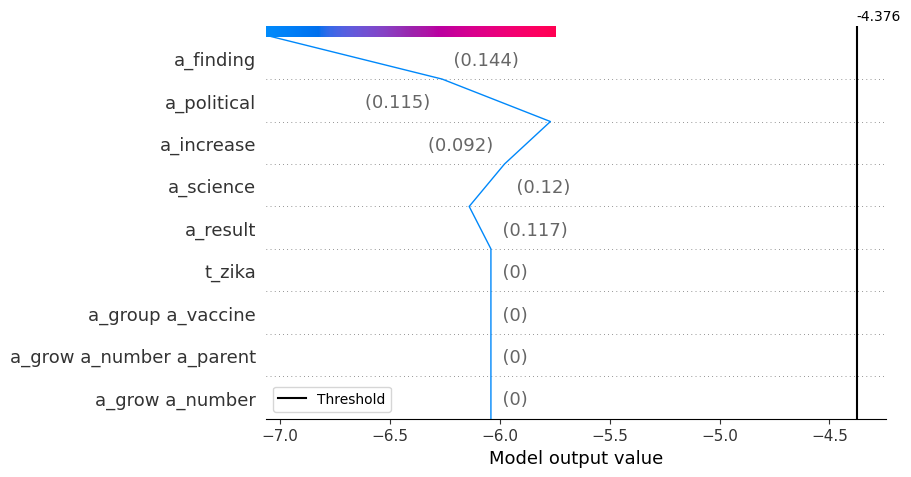

Truth: 0
Prediction: [0]
Shap value: -6.063197137790153
Prediction score: [-6.06319711]


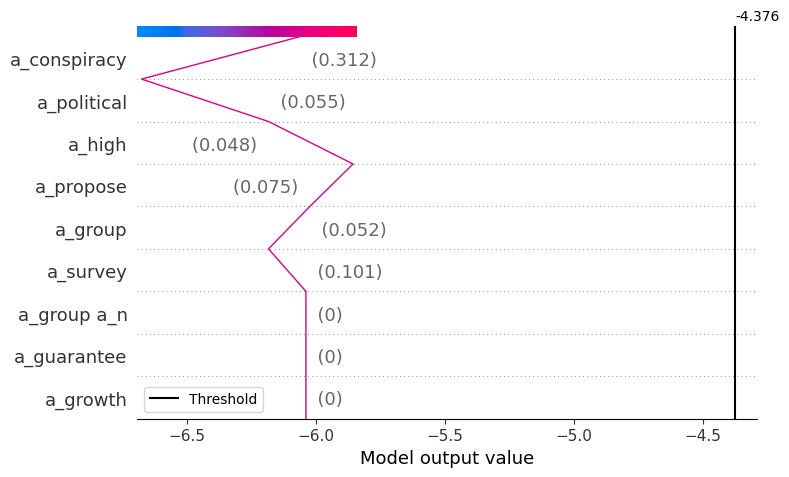

In [21]:
import numpy as np

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test[i], threshold)}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test[i])}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()